In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import iris
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
ena = {'lat': 39, 'lon': 360 - 28}

## Load datasets

In [2]:
ds_obs = xr.open_dataset('/Users/jone003/tmp/EAGLES/arm_data/enainterpolatedsondeC1.c1.20170718.000030.nc')
ds_obs

<xarray.Dataset>
Dimensions:            (height: 332, time: 1440)
Coordinates:
  * time               (time) datetime64[ns] 2017-07-18T00:00:30 ... 2017-07-18T23:59:30
  * height             (height) float32 0.03048 0.05048 ... 40.510487 41.010487
Data variables:
    base_time          datetime64[ns] ...
    time_offset        (time) datetime64[ns] ...
    precip             (time) float32 ...
    qc_precip          (time) int32 ...
    temp               (time, height) float32 ...
    qc_temp            (time, height) int32 ...
    source_temp        (time, height) float64 ...
    rh                 (time, height) float32 ...
    qc_rh              (time, height) int32 ...
    source_rh          (time, height) float64 ...
    vap_pres           (time, height) float32 ...
    qc_vap_pres        (time, height) int32 ...
    bar_pres           (time, height) float32 ...
    qc_bar_pres        (time, height) int32 ...
    source_bar_pres    (time, height) float64 ...
    wspd             

In [3]:
ds_era = xr.open_dataset('ERA5_ENA_20170717-20170719_with_height_and_presl.nc')
ds_era

<xarray.Dataset>
Dimensions:                (lat: 9, lev: 137, lon: 9, time: 72)
Coordinates:
  * time                   (time) datetime64[ns] 2017-07-17 ... 2017-07-19T23:00:00
  * lat                    (lat) float32 40.0 39.75 39.5 ... 38.5 38.25 38.0
  * lon                    (lon) float32 331.0 331.25 331.5 ... 332.75 333.0
  * lev                    (lev) float32 1.0 2.0 3.0 4.0 ... 135.0 136.0 137.0
Data variables:
    TMP                    (time, lev, lat, lon) float32 ...
    SPFH                   (time, lev, lat, lon) float32 ...
    UGRD                   (time, lev, lat, lon) float32 ...
    VGRD                   (time, lev, lat, lon) float32 ...
    GP                     (time, lat, lon) float32 ...
    NLPRES                 (time, lat, lon) float32 ...
    initial_time0_encoded  (time) float64 ...
    initial_time0          (time) |S18 ...
    height                 (lev, time, lat, lon) float64 ...
    pressure               (lev, time, lat, lon) float64 ...
Attrib

# Compare ERA5 reanalysis to ARM obs at ENA site

In [4]:
zobs = ds_obs['height']
height = ds_era['height']  # dims ('lev', 'time', 'lat', 'lon')

In [5]:
# optionally interpolate ds_era to same height levels as obs ds
# should make it easier to compare directly, but not really needed if just plotting
def interp_to_height(ds_era, height_obs):
    height = ds_era['height'].transpose('time', 'lev', 'lat', 'lon')  # originally (lev, time, lat, lon)
    height = height[:, ::-1, :, :]  # ordered as increasing height
    ax0 = height.dims.index('lev')
    
    var_list = [v for v in ds_era if 'lev' in ds_era[v].dims]  # time, lev, lat, lon
    
    time = ds_era.time.values
    lat = ds_era.lat.values
    lon = ds_era.lon.values
    ntime = len(time)
    nlat = len(lat)
    nlon = len(lon)
    nheight = len(height_obs)
    out_shape = (ntime, nheight, nlat, nlon)
    
    ds_out = xr.Dataset()
    ds_out['height'] = height_obs
    # easiest to just loop over columns (even if that feels dumb)
    # new output has shape time, nheight, nlat, nlon
    for v in var_list:
        print(v)
        if v == 'height':
            continue
        # note: need to reverse order so height increases
        arr_in = ds_era[v].transpose('time', 'lev', 'lat', 'lon').values[:, ::-1, :, :]
        arr_out = np.full(out_shape, np.nan)
        print(arr_out.shape)
        print(arr_in.shape)
        for jt in range(ntime):
            for jlat in range(nlat):
                for jlon in range(nlon):
                    arr_out[jt, :, jlat, jlon] = np.interp(height_obs.values,
                                                           height[jt, :, jlat, jlon],
                                                           arr_in[jt, :, jlat, jlon])
        da = xr.DataArray(arr_out, coords=[time, height_obs, lat, lon],
                          dims=['time', 'height', 'lat', 'lon'],
                          name=v,
                          attrs=ds_era[v].attrs)
        ds_out[v] = da.copy(deep=True)
    return ds_out

In [6]:
ds_era_height = interp_to_height(ds_era, zobs)
ds_era_height

TMP
(72, 332, 9, 9)
(72, 137, 9, 9)
SPFH
(72, 332, 9, 9)
(72, 137, 9, 9)
UGRD
(72, 332, 9, 9)
(72, 137, 9, 9)
VGRD
(72, 332, 9, 9)
(72, 137, 9, 9)
height
pressure
(72, 332, 9, 9)
(72, 137, 9, 9)


<xarray.Dataset>
Dimensions:   (height: 332, lat: 9, lon: 9, time: 72)
Coordinates:
  * height    (height) float32 0.03048 0.05048 ... 40.510487 41.010487
  * time      (time) datetime64[ns] 2017-07-17 ... 2017-07-19T23:00:00
  * lat       (lat) float32 40.0 39.75 39.5 39.25 39.0 38.75 38.5 38.25 38.0
  * lon       (lon) float32 331.0 331.25 331.5 331.75 ... 332.5 332.75 333.0
Data variables:
    TMP       (time, height, lat, lon) float64 294.9 294.6 294.5 ... 261.7 261.8
    SPFH      (time, height, lat, lon) float64 0.01439 0.01403 ... 3.702e-06
    UGRD      (time, height, lat, lon) float64 5.04 4.342 4.054 ... -31.5 -31.63
    VGRD      (time, height, lat, lon) float64 6.525 6.75 ... -2.468 -2.478
    pressure  (time, height, lat, lon) float64 1.023e+05 1.023e+05 ... 265.1

In [7]:
theta = ds_era_height['TMP'] * (1000 * 100 / ds_era_height['pressure']) ** (0.286)
theta.attrs = {'units': 'K', 'long_name': 'potential temperature'}
ds_era_height['potential_temp'] = theta
ds_era_height

<xarray.Dataset>
Dimensions:         (height: 332, lat: 9, lon: 9, time: 72)
Coordinates:
  * height          (height) float32 0.03048 0.05048 ... 40.510487 41.010487
  * time            (time) datetime64[ns] 2017-07-17 ... 2017-07-19T23:00:00
  * lat             (lat) float32 40.0 39.75 39.5 39.25 ... 38.5 38.25 38.0
  * lon             (lon) float32 331.0 331.25 331.5 ... 332.5 332.75 333.0
Data variables:
    TMP             (time, height, lat, lon) float64 294.9 294.6 ... 261.7 261.8
    SPFH            (time, height, lat, lon) float64 0.01439 ... 3.702e-06
    UGRD            (time, height, lat, lon) float64 5.04 4.342 ... -31.5 -31.63
    VGRD            (time, height, lat, lon) float64 6.525 6.75 ... -2.478
    pressure        (time, height, lat, lon) float64 1.023e+05 ... 265.1
    potential_temp  (time, height, lat, lon) float64 293.0 292.7 ... 1.428e+03

In [8]:
(ds_obs.lat.item(), ds_obs.lon.item())

(39.09159851074219, -28.025699615478516)

In [9]:
(ds_era.lat.values, ds_era.lon.values - 360)

(array([40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 , 38.25, 38.  ],
       dtype=float32),
 array([-29.  , -28.75, -28.5 , -28.25, -28.  , -27.75, -27.5 , -27.25,
        -27.  ], dtype=float32))

In [10]:
# for initial comparison, select lat, lon = (39, -28)
ds_era_ena = ds_era.sel(**ena, time='2017-07-18')
if 'lev' in ds_era_height:
    ds_era_height_ena = ds_era_height.drop('lev').sel(**ena, time='2017-07-18')
else:
    ds_era_height_ena = ds_era_height.sel(**ena, time='2017-07-18')    

In [11]:
ds_era_height_ena

<xarray.Dataset>
Dimensions:         (height: 332, time: 24)
Coordinates:
  * height          (height) float32 0.03048 0.05048 ... 40.510487 41.010487
  * time            (time) datetime64[ns] 2017-07-18 ... 2017-07-18T23:00:00
    lat             float32 39.0
    lon             float32 332.0
Data variables:
    TMP             (time, height) float64 295.7 295.6 295.4 ... 256.8 258.6
    SPFH            (time, height) float64 0.01567 0.01564 ... 3.723e-06
    UGRD            (time, height) float64 8.585 9.268 9.736 ... -28.8 -30.88
    VGRD            (time, height) float64 -1.393 -1.603 ... -7.385 -6.744
    pressure        (time, height) float64 1.018e+05 1.016e+05 ... 284.9 267.0
    potential_temp  (time, height) float64 294.2 294.3 ... 1.373e+03 1.408e+03

In [12]:
# to do: take this as hourly averages instead of instantaneous
ds_obs_hourly = ds_obs.sel(time=ds_era_height_ena.time, method='nearest')

In [16]:
# durr, this was really easy to do.
ds_obs_hourly = ds_obs.resample(time='1H').mean()
ds_obs_hourly

<xarray.Dataset>
Dimensions:            (height: 332, time: 24)
Coordinates:
  * time               (time) datetime64[ns] 2017-07-18 ... 2017-07-18T23:00:00
  * height             (height) float32 0.03048 0.05048 ... 40.510487 41.010487
Data variables:
    precip             (time) float32 0.0 0.0 0.0 0.0 ... 8.3333333e-07 0.0 0.0
    qc_precip          (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    temp               (time, height) float32 22.19273 22.217276 ... nan nan
    qc_temp            (time, height) float64 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0
    source_temp        (time, height) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    rh                 (time, height) float32 94.79914 93.27482 ... nan nan
    qc_rh              (time, height) float64 0.0 0.0 0.0 0.0 ... 4.0 4.0 4.0
    source_rh          (time, height) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    vap_pres           (time, height) float32 2.5351167 2.4980872 ... nan nan
    qc_vap_pres        (time, height) float64 

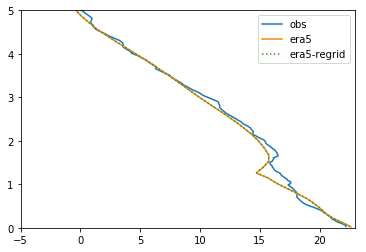

In [20]:
# sanity check to verify regridding of era5 was reasonable
i = 0
z_obs = ds_obs_hourly.height
plt.plot(ds_obs_hourly.temp.isel(time=i), z_obs)
plt.plot(ds_era_ena.TMP.isel(time=i) - 273.15, ds_era_ena.height.isel(time=0))
plt.plot(ds_era_height_ena.TMP.isel(time=i) - 273.15, ds_era_height_ena.height,':')
plt.ylim([0, 5])
plt.xlim([-5, 23])
plt.legend(['obs', 'era5', 'era5-regrid'])

In [21]:
# join era and obs:
ds1 = ds_era_height_ena.rename({'TMP': 'temp',
                                'UGRD': 'u_wind',
                                'VGRD': 'v_wind',
                                'SPFH': 'sh'}).drop(['lat', 'lon'])
if ds1['temp'].min() > 50:
    # convert to celsius
    ds1['temp'].values = ds1['temp'].values - 273.15
vars_to_combine = ['temp', 'u_wind', 'v_wind', 'sh']
ds_combined = xr.concat([ds1[vars_to_combine], ds_obs_hourly[vars_to_combine]],
                        dim=pd.Index(('ERA5', 'Obs'), name='data'))

In [22]:
ds_combined

<xarray.Dataset>
Dimensions:  (data: 2, height: 332, time: 24)
Coordinates:
  * height   (height) float32 0.03048 0.05048 ... 40.510487 41.010487
  * time     (time) datetime64[ns] 2017-07-18 ... 2017-07-18T23:00:00
  * data     (data) object 'ERA5' 'Obs'
Data variables:
    temp     (data, time, height) float64 22.55 22.42 22.28 ... nan nan nan
    u_wind   (data, time, height) float64 8.585 9.268 9.736 ... nan nan nan
    v_wind   (data, time, height) float64 -1.393 -1.603 -1.794 ... nan nan nan
    sh       (data, time, height) float64 0.01567 0.01564 0.01562 ... nan nan

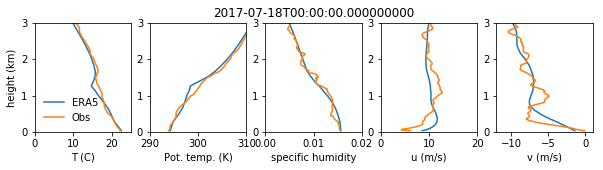

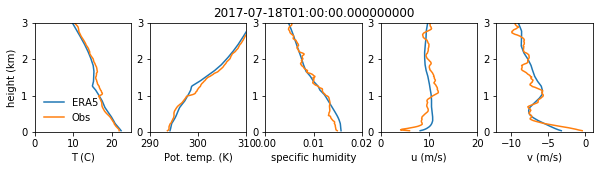

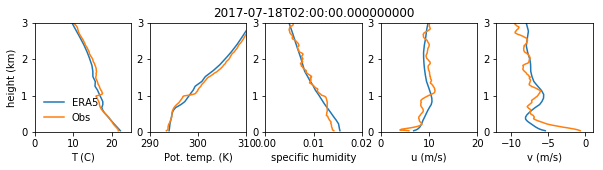

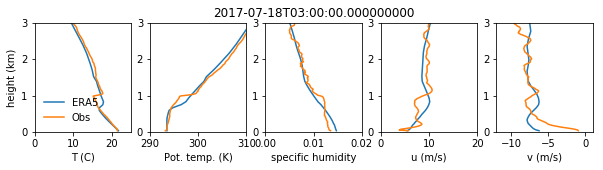

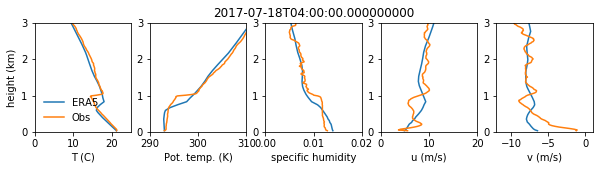

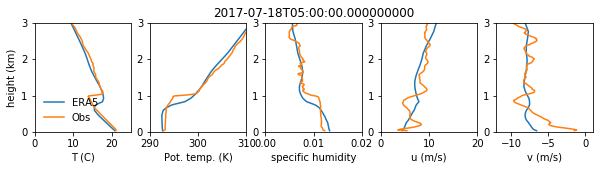

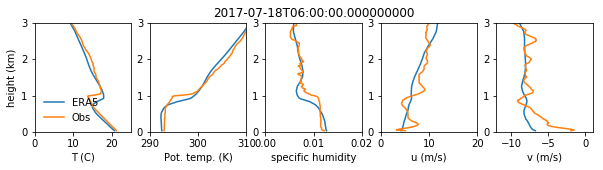

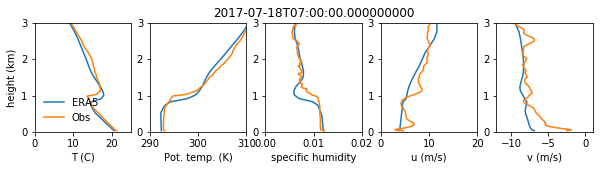

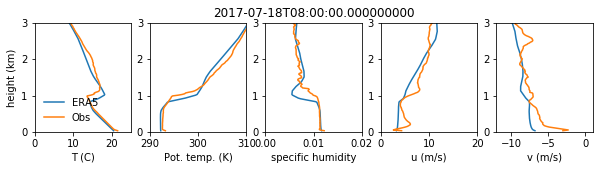

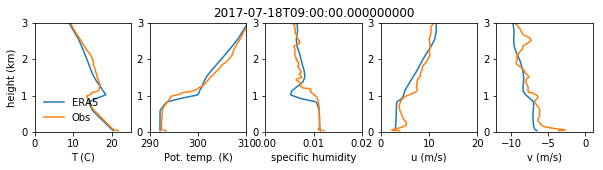

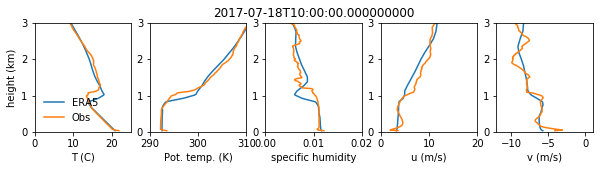

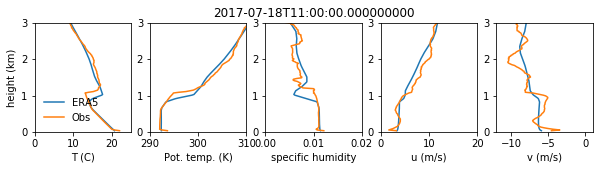

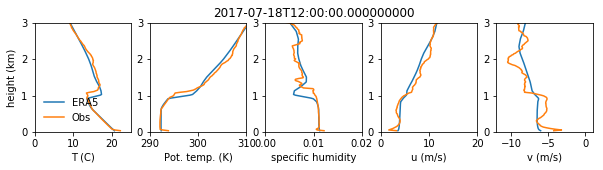

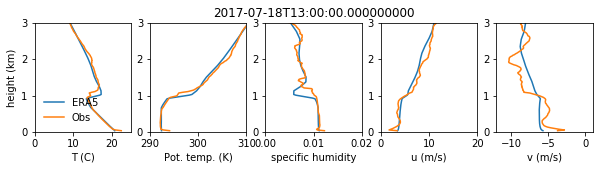

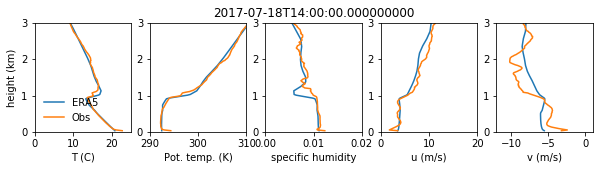

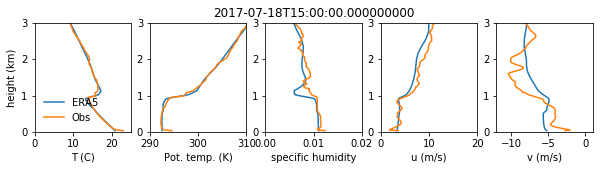

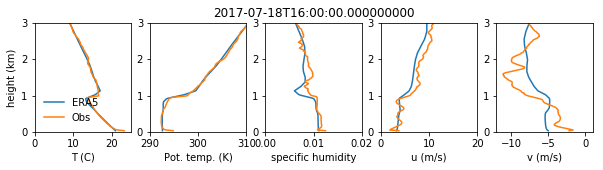

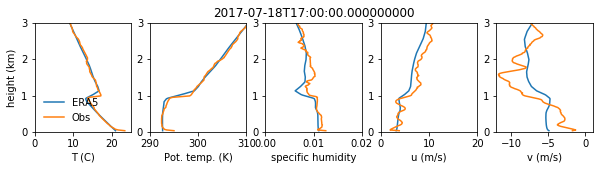

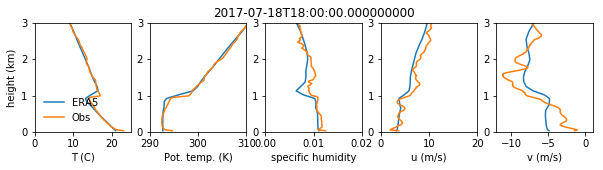

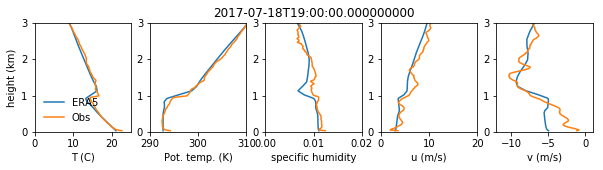

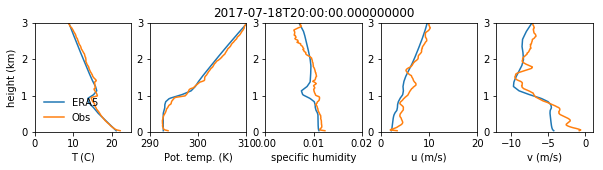

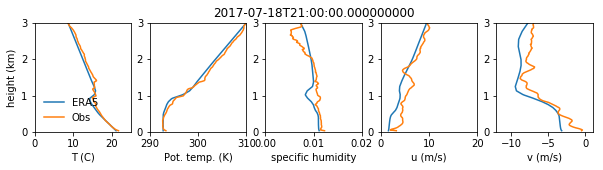

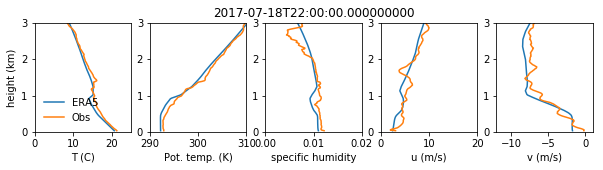

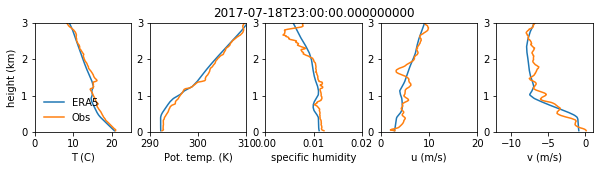

In [28]:
# make a long set of plots:
# all together together: 
#    fig, axes = plt.subplots(ncols=5, nrows=24, figsize=(8, 48)
# but, it looks better if they're all separate instead

save_fig = True
z = ds_combined.height
ylims = [0, 3]
xlims = [(0, 25), (290, 310), (0, 0.02), (0, 20), (-12, 1)]
ylab = 'height (km)'
xlab = ['T (C)', 'Pot. temp. (K)', 'specific humidity', 'u (m/s)', 'v (m/s)']
for n in range(len(ds1.time)):
    fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(10, 2))
    for j, v in enumerate(['temp', 'potential_temp', 'sh', 'u_wind', 'v_wind']):
        ax = axes[j]  
        ax.plot(ds1[v].isel(time=n), z)
        ax.plot(ds_obs_hourly[v].isel(time=n), z)
        ax.set_ylim(ylims)
        ax.set_xlim(xlims[j])
        if (j == 0):
            ax.legend(['ERA5', 'Obs'], frameon=False)
        if j == 0:
            ax.set_ylabel(ylab)
        if j == 2:
            ax.set_title(ds1.time.values[n])
        ax.set_xlabel(xlab[j])
    if save_fig:
        out_name = f'era5_v_obs_ena_20170718_{n:02}.png'
        fig.savefig(out_name)
    plt.show()